In [64]:
import seaborn as sns
import pandas as pd

Activating license key

In [81]:
from quantrocket.license import set_license

In [82]:
set_license("417cd5cc-ddf1-11ee-898f-f17360435438")

{'licensekey': '417c........5438', 'software_license': {}}

Create database 

In [ ]:
from quantrocket.history import create_usstock_db
create_usstock_db("usstock-free-1d", free=True)


In [22]:
from quantrocket.history import get_db_config
get_db_config("usstock-free-1d")

{'vendor': 'usstock',
 'bar_size': '1 day',
 'universe': 'FREE',
 'shard': 'year',
 'fields': ['Symbol',
  'Open',
  'High',
  'Low',
  'Close',
  'Volume',
  'Vwap',
  'TotalTrades',
  'UnadjOpen',
  'UnadjHigh',
  'UnadjLow',
  'UnadjClose',
  'UnadjVolume',
  'UnadjVwap']}

In [23]:
from quantrocket.history import list_databases
list_databases()

['usstock-free-1d']

In [ ]:
Download clo

In [ ]:
import pandas as pd
from quantrocket.history import download_history_file
download_history_file("usstock-free-1d",
                          start_date="2023-01-01",
                          end_date="2023-12-31",
                          fields=["Close"],
                          sids= ["FIBBG000B9XRY4"],  # AAPL's sid
                          filepath_or_buffer="price_data.csv")
df = pd.read_csv("price_data.csv", parse_dates=["Date"])
#.head()

Read CSV file into pandas DataFrame df

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("price_data.csv", parse_dates=["Date"])
#Sid is not required so drop it
df=df.drop(['Sid'],axis=1)



Set option for displaying all rows

In [73]:
pd.set_option("display.max_rows",df.shape[0])

In [74]:
print(df)

          Date     Close
0   2023-01-03  124.2163
1   2023-01-04  125.4975
2   2023-01-05  124.1666
3   2023-01-06  128.7352
4   2023-01-09  129.2616
5   2023-01-10  129.8377
6   2023-01-11  132.5788
7   2023-01-12  132.4994
8   2023-01-13  133.8402
9   2023-01-17  135.0121
10  2023-01-18  134.2871
11  2023-01-19  134.3467
12  2023-01-20  136.9289
13  2023-01-23  140.1468
14  2023-01-24  141.5571
15  2023-01-25  140.8917
16  2023-01-26  142.9774
17  2023-01-27  144.9339
18  2023-01-30  142.0239
19  2023-01-31  143.3051
20  2023-02-01  144.4373
21  2023-02-02  149.7905
22  2023-02-03  153.4454
23  2023-02-06  150.6943
24  2023-02-07  153.5944
25  2023-02-08  150.8830
26  2023-02-09  149.8402
27  2023-02-10  150.2082
28  2023-02-13  153.0332
29  2023-02-14  152.3866
30  2023-02-15  154.5053
31  2023-02-16  152.8939
32  2023-02-17  151.7401
33  2023-02-21  147.6917
34  2023-02-22  148.1194
35  2023-02-23  148.6068
36  2023-02-24  145.9311
37  2023-02-27  147.1346
38  2023-02-28  146.6273


In [30]:
df.head()

,Date,Close
0,2023-01-03,124.2163
1,2023-01-04,125.4975
2,2023-01-05,124.1666
3,2023-01-06,128.7352
4,2023-01-09,129.2616


Compute Returns and State

In [75]:
import pandas as pd
import numpy as np

df['Date'] = pd.to_datetime(df['Date'])
df['Returns'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1))
df['State'] = np.where(df['Returns'] >= 0.01, 1, np.where((df['Returns'] > -0.01) & (df['Returns'] < 0.01), 0, -1))




In [76]:
df['State'].value_counts()

 0    158
 1     56
-1     36
Name: State, dtype: int64

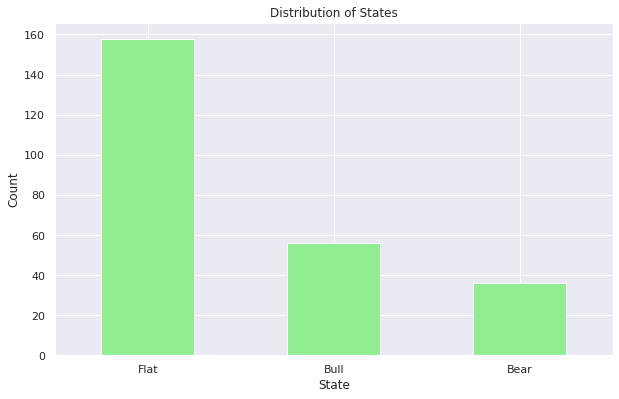

In [77]:
df['State'].value_counts()
df['State'] = df['State'].replace({-1: 'Bear', 1: 'Bull', 0: 'Flat'})
plt.figure(figsize=(10, 6))
ax = df['State'].value_counts().plot(kind='bar', color='lightgreen')

# Rotate x-axis labels horizontally
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.title('Distribution of States')
plt.xlabel('State')
plt.ylabel('Count')
plt.show()
df['State'] = df['State'].replace({ 'Bear':-1,  'Bull':1, 'Flat':0})


Compute Portfolio Value and Optimal Buy Indices

In [78]:

#Assuming that initial portfolio value is 0 at the start of the year 2023
df['Portfolio_Value'] = 0

for i in range(1, len(df)):
    if df.at[i, 'State'] == 1 and df.at[i-1, 'State'] == 0 :
        df.at[i, 'Portfolio_Value'] = df.at[i-1, 'Portfolio_Value'] + 1
    elif df.at[i, 'State'] == -1 and df.at[i-1, 'State'] == 0:
        df.at[i, 'Portfolio_Value'] = df.at[i-1, 'Portfolio_Value'] 
    else:
        df.at[i, 'Portfolio_Value'] = df.at[i-1, 'Portfolio_Value']

optimal_buy_indices = df.loc[(df['State'] == 1) & (df['State'].shift(1) == 0)].index

print("Final Portfolio Value:", df['Portfolio_Value'].iloc[-1])
print("Optimal Buy Indices:", list(optimal_buy_indices))


Final Portfolio Value: 40
Optimal Buy Indices: [6, 8, 12, 16, 21, 28, 30, 41, 50, 52, 59, 61, 69, 79, 85, 88, 94, 100, 103, 108, 110, 113, 117, 120, 123, 133, 142, 160, 164, 177, 187, 191, 207, 209, 212, 216, 218, 232, 234, 238]


Compute Transition Matrix

In [79]:
import pandas as pd
states_list=sorted(list(df['State'].unique()))
transition_matrix = pd.DataFrame(index=states_list, columns=states_list, dtype=float)

# Initialize transition matrix with zeros
for state in df['State'].unique():
    transition_matrix.loc[state] = 0.0

# Calculate transition probabilities using count of each time the transition has occured in the year
for i in range(1, len(df)):
    prev_state = df['State'].iloc[i-1]
    curr_state = df['State'].iloc[i]
    transition_matrix.loc[prev_state, curr_state] += 1

# Normalize transition matrix
for state in df['State'].unique():
    transition_matrix.loc[state] /= transition_matrix.loc[state].sum()

# Display the transition matrix
print(transition_matrix)


          -1         0         1
-1  0.138889  0.722222  0.138889
 0  0.146497  0.598726  0.254777
 1  0.125000  0.678571  0.196429
